### Notebook para analisar os corpora PetroNER

In [1]:
from conllu import parse_incr, parse
from owlready2 import *
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
import numpy as np

Carregando os corpora e a ontologia

In [2]:
# CONLLU parser

# Corpora completo
PetroNER = open("petroner-uri-2023-04-05.conllu", "r", encoding="utf-8")
PetroNER_sentences = parse_incr(PetroNER)

# Corpora treino
PetroNER_treino = open("petroner-uri-treino.conllu", "r", encoding="utf-8")
PetroNER_treino_sentences = parse_incr(PetroNER_treino)

# Corpora validação
PetroNER_valid = open("petroner-uri-validação.conllu", "r", encoding="utf-8")
PetroNER_valid_sentences = parse_incr(PetroNER_valid)

# Corpora teste
PetroNER_teste = open("petroner-uri-teste.conllu", "r", encoding="utf-8")
PetroNER_teste_sentences = parse_incr(PetroNER_teste)

In [4]:
#OntoGeoLógica povoda (OntoGeoLogicaPovoadaInstanciasRelacoes.owl)
onto_povoada = get_ontology("../../KnowledgeGraph/OntoGeoLogicaInstancias.owl")
onto_povoada.load()

#OntoGeoLógica não povoda (OntoGeoLogicaPython.owl)
onto = get_ontology("../../KnowledgeGraph/OntoGeoLogicaEntidadesNomeadas.owl")
onto.load()


get_ontology("http://www.semanticweb.org/bg40/ontologies/2022/5/untitled-ontology-2#")

Função que recebe o texto anotado em formato CONLLU e processa para o treinamento. Tem como saída as sentenças acrescida das tags para indicar as entidades, bem como com a entidade no início do texto; lista com as entidades (instâncias extraídas do texto); lista com as classes que as entidades pertencem; e lista com as URI referente às entidades. O texto sai com o seguinte formato:  
"[Nome da classe] Nome da entidade | blablabla blablabla blablabla [E] Nome da entidade [/E] blablabla blablabla." 

In [5]:
# Função que recebe
def preparar_dataset(tokenlist):

    #sent = TokenList([])
    sent_orig = ''   # String para compor a sentença original
    sents_NER = []   # Lista para armazenar as sentenças com indicação das entidades
    NER_on = False   # Variável para indicar se está iterando por token de entidades
    NER_tok = ''     # string para armazenar os tokens das entidades que estão sendo iteradas
    MW_on = False    # Variável para indicar se está iterando por tolkens multiword
    MW_tok = ''      # string para armazenar o termo multiword
    MW_end = 0       # ID final do token multiword
    ENT = []         # Lista para armazenar as entidades encontradas no texto
    ENT_class = []   # Lista para armazenar as classes das entidades encontradas no texto
    ENT_URI = []     # Lista para armazenar as URI das entidades encontradas no texto

    #Iterando por todos os tokens de uma sentença
    for tok in tokenlist:
        # ignorando id não inteiro (tuplas), ou seja token multiword
        if type(tok['id']) == int:

            # Verifica se o token inicia uma entidade ("B")
            if tok['deps'][0] == 'B':
                
                # Verifica se a variável NER_on está ativado (No caso de um tok "B" seguido de outro)
                if NER_on == True:
                    
                    NER_on = False  # Desativa a variável NER_on

                    # Para sentença mais recente da lista sents_NER, inclui a entidade no início e o marcador [/E] no final 
                    sents_NER[-1] = '[' + ENT_class[-1] + '] ' + NER_tok + '| ' + sents_NER[-1].strip() + ' [/E]'

                    # Incluir o NER_tok na lista ENT
                    ENT.append(NER_tok.strip())

                    NER_tok = '' # Apaga a string NER_tok

                NER_on = True  # Ativa a variável NER_on
                # Acrescenta uma sentença com o marcador [E] na listas de sentenças com NER
                sents_NER.append(sent_orig + ' [E]')
                # Incluir classe na lista ENT_class
                ENT_class.append(tok['deps'][2:])
                # Incluir URI da entidade na lista ENT_URI. Caso não haja URI, incluir "None". 
                try:
                    ENT_URI.append(tok['misc']['grafo'])
                except:
                    ENT_URI.append(None)

            # Identifica o primeiro token "O" após uma sequência de entidades
            if (tok['deps'][0] == 'O') & NER_on:
                
                NER_on = False  # Desativa a variável NER_on

                # Para sentença mais recente da lista sents_NER, 
                # inclui a classe e a entidade no início e o marcador [/E] no final 
                sents_NER[-1] = '[' + ENT_class[-1] + '] ' + NER_tok + '| ' + sents_NER[-1].strip() + ' [/E]'

                # Incluir o NER_tok na lista ENT
                ENT.append(NER_tok.strip())

                NER_tok = '' # Apaga a string NER_tok
                
            # Identifica se o último token da sequência tem o marcador "B" ou "I".    
            if (tokenlist[-1]['id'] == tok['id']) & ((tok['deps'][0] == 'B') | (tok['deps'][0] == 'I')):
                NER_on = False  # Desativa a variável NER_on

                # Para sentença mais recente da lista sents_NER, 
                # inclui a classe e a entidade no início e o marcador [/E] no final 
                sents_NER[-1] = '[' + ENT_class[-1] + '] ' + NER_tok + '| ' + sents_NER[-1].strip() + ' [/E]'

                # Incluir o NER_tok na lista ENT
                ENT.append(NER_tok.strip())

                NER_tok = '' # Apaga a string NER_tok

            # Verifica se está iterando por uma multiword ou não
            if not MW_on:

                # Acrecenta o token à string da entidade
                if NER_on:
                    NER_tok = NER_tok + tok['form'] + ' '

                # Se o token for uma pontuação, não inclui espaço entre o token anterior 
                if tok['upos'] == 'PUNCT':
                    # O token é incluído na senteça original e em todas as sentenças da lista sents_NER
                    sent_orig = sent_orig + tok['form']
                    for i in range(len(sents_NER)):
                        sents_NER[i] = sents_NER[i] + tok['form']
                else:
                    sent_orig = sent_orig + ' ' + tok['form']
                    for i in range(len(sents_NER)):
                        sents_NER[i] = sents_NER[i] + ' ' + tok['form']

            else:
                # Se o token for o último termo da multiword, desativamos a variável MW_on
                if tok['id'] == MW_end:
                    MW_on = False

                    # Acrecenta a multiword à string da entidade
                    if NER_on:
                        NER_tok = NER_tok + MW_tok + ' '

                    #Ao invés de incluir nas senteças o token, vamos incluir o MW_tok 
                    # Se o token for uma pontuação, não inclui espaço entre o token anterior 
                    if tok['upos'] == 'PUNCT':
                        # O token é incluído na senteça original e em todas as sentenças da lista sents_NER
                        sent_orig = sent_orig + MW_tok
                        for i in range(len(sents_NER)):
                            sents_NER[i] = sents_NER[i] + MW_tok
                    else:
                        sent_orig = sent_orig + ' ' + MW_tok
                        for i in range(len(sents_NER)):
                            sents_NER[i] = sents_NER[i] + ' ' + MW_tok

        # Se a ID do token for referente a uma multiword, ativamos a variável MW_on, 
        # armazenamos o termo MW_tok e o valor da 'id' final
        else:
            MW_on = True
            MW_tok = tok['form']
            MW_end = tok['id'][-1]
    
    return(sents_NER, ENT, ENT_class, ENT_URI)

Função que itera por todas as sentenças de um corpora e retorna as listas com as sentenças, entidades, classes e URI

In [6]:
def ent_class_URI(sentences):

    # Separando as listas de sentenças, entidades, classes e URI
    text = []
    entities = []
    classes_NER = [] 
    ENT_URI = []
    entities_sem_URI = []

    # Iterando por todas as sentenças em formato CONLLU para preparar o dataset
    n = 0
    m = 0
    
    for tokenlist in sentences:
        # contador de sentenças
        n = n + 1
        # processando cada sentenças
        text_n, entities_n, classes_NER_n, ENT_URI_n = preparar_dataset(tokenlist)
        
        #Pular se a sentença não possui entidade
        if ENT_URI_n != []:
            
            # Contador de sentenças com entidades
            if len(text_n) > 0:
                m = m + 1
        
            #iterando pelas entidades das sentenças
            for i in range(len(ENT_URI_n)):


                # Quebrando as entidades que possuem mais de um URI (ex: "#Aptian,#Miocene" e "#Cenozoic,#Mesozoic")        

                try:
                    #Alterar separadores anotados errados
                    URI_unidas = ENT_URI_n[i].replace('; #', ',#')
                    URI_unidas = URI_unidas.replace(' / #', ',#')
                    ENT_URI_split = list(set(URI_unidas.split(',#')))
                except:
                    ENT_URI_split = [ENT_URI_n[i]]

                #iterando pelas quebradas entidades 
                text_new = []
                entities_new = []
                classes_NER_new = []
                ENT_URI_new = []

                for ent in ENT_URI_split:
                    try:
                        if ent[0] != '#':
                            ent = '#' + ent
                    except:
                        pass

                    ENT_URI_new.append(ent)
                    # O texto, a entidade no texto e a classe são repetidas quando existem multiplas URI para uma mesma entidade
                    text_new.append(text_n[i])
                    entities_new.append(entities_n[i])
                    classes_NER_new.append(classes_NER_n[i])


                text = text + text_new
                entities = entities + entities_new
                classes_NER = classes_NER + classes_NER_new
                ENT_URI = ENT_URI + ENT_URI_new

    print('Total de sentenças no arquivo: ', n)
    print('N° de sentenças com entidades: ', m, 'que equivale a ', (m/n)*100, '% do total')
    print ('N° de entidades: ', len(entities))
    print('N° de classes: ', len(classes_NER))
    print('Média de ', len(entities)/m, 'entidades por sentença (das sentenças que possuem entidades)')
    
    #Verificando entidades sem URI
    for i in range(len(ENT_URI)):
        if ENT_URI[i] == None:
            entities_sem_URI.append(entities[i])
        
    print('N° de entities com URI: ', len(ENT_URI) - len(entities_sem_URI))
    print('N° de entities sem URI: ', len(entities_sem_URI))
    print((len(entities_sem_URI)/len(ENT_URI))*100, '% das entidades não possuem URI.')
    
    return (text, entities, classes_NER, ENT_URI, entities_sem_URI)

In [7]:
print('PetroNER')
PetroNER_text, PetroNER_entities, PetroNER_classes_NER, PetroNER_ENT_URI, PetroNER_entities_sem_URI = ent_class_URI(PetroNER_sentences)

print('\nPetroNER - Treino')
treino_text, treino_entities, treino_classes_NER, treino_ENT_URI, treino_entities_sem_URI = ent_class_URI(PetroNER_treino_sentences)

print('\nPetroNER - Validação')
valid_text, valid_entities, valid_classes_NER, valid_ENT_URI, valid_entities_sem_URI = ent_class_URI(PetroNER_valid_sentences)

print('\nPetroNER - Teste')
teste_text, teste_entities, teste_classes_NER, teste_ENT_URI, teste_entities_sem_URI = ent_class_URI(PetroNER_teste_sentences)

PetroNER
Total de sentenças no arquivo:  24035
N° de sentenças com entidades:  8757 que equivale a  36.434366548783025 % do total
N° de entidades:  19278
N° de classes:  19278
Média de  2.2014388489208634 entidades por sentença (das sentenças que possuem entidades)
N° de entities com URI:  18609
N° de entities sem URI:  669
3.4702769996887644 % das entidades não possuem URI.

PetroNER - Treino
Total de sentenças no arquivo:  17987
N° de sentenças com entidades:  6527 que equivale a  36.28731861900261 % do total
N° de entidades:  14277
N° de classes:  14277
Média de  2.1873755170828866 entidades por sentença (das sentenças que possuem entidades)
N° de entities com URI:  13858
N° de entities sem URI:  419
2.9347902220354416 % das entidades não possuem URI.

PetroNER - Validação
Total de sentenças no arquivo:  2467
N° de sentenças com entidades:  892 que equivale a  36.15727604377787 % do total
N° de entidades:  1785
N° de classes:  1785
Média de  2.0011210762331837 entidades por sentença

In [8]:
print('Verificando se o número de senteças do PetroNER bate com as sentenças divididas entre Treino - Validação - Teste')
17987 + 2467 + 3581 == 24035

Verificando se o número de senteças do PetroNER bate com as sentenças divididas entre Treino - Validação - Teste


True

In [9]:
print('Entidades sem URI:')
set(PetroNER_entities_sem_URI)

Entidades sem URI:


{'',
 'Bendian',
 'Cimentos',
 'Estrada Nova',
 'Formações Sulay',
 'Gerador',
 'Geração',
 'Jiquiá',
 'Lampasan',
 'Palmeira',
 'Pirapema',
 'RB-1',
 'Ratawi',
 'Rio Panon',
 'Robalo',
 'Série Lampasan',
 'Volta Redonda',
 'Zu-bair',
 'alongados',
 'cimento',
 'cimentos',
 'contato irregular',
 'cruzada',
 'dendríticas',
 'extrusivas vulcânicas',
 'foliação',
 'foliações',
 'formação Aliança',
 'gerador',
 'geradora',
 'geradoras',
 'geradores',
 'geração',
 'grãos de origem vulcânica',
 'intrusiva vulcânica',
 'intrusivas vulcânicas',
 'laminação',
 'laminação horizontal',
 'lavas vulcânicas',
 'lineação',
 'lineações',
 'migração',
 'milonitica',
 'milonítica',
 'miloníticas',
 'molde',
 'moldes',
 'ondulada',
 'preservação',
 'puil-apart',
 'rachas geradoras',
 'remigração',
 'remigrações',
 'rocha geradora',
 'rocha reservatório',
 'rochas geradoras',
 'rochas reservatório',
 'rochas reservatórios',
 'selo',
 'selos',
 'septárias',
 'soterramento',
 'trapa',
 'trapas',
 'vidro vul

### Salvando PetroNER para entity link

In [10]:
#Treino

with open('../PetroNER-LinkedEntity/treino - sentences.npy', 'wb') as f:
    np.save(f, np.array(treino_text))
with open('../PetroNER-LinkedEntity/treino - entities.npy', 'wb') as f:
    np.save(f, np.array(treino_entities))
with open('../PetroNER-LinkedEntity/treino - classes.npy', 'wb') as f:
    np.save(f, np.array(treino_classes_NER))
with open('../PetroNER-LinkedEntity/treino - URI.npy', 'wb') as f:
    np.save(f, np.array(treino_ENT_URI))
    
#Validação

with open('../PetroNER-LinkedEntity/valid - sentences.npy', 'wb') as f:
    np.save(f, np.array(valid_text))
with open('../PetroNER-LinkedEntity/valid - entities.npy', 'wb') as f:
    np.save(f, np.array(valid_entities))
with open('../PetroNER-LinkedEntity/valid - classes.npy', 'wb') as f:
    np.save(f, np.array(valid_classes_NER))
with open('../PetroNER-LinkedEntity/valid - URI.npy', 'wb') as f:
    np.save(f, np.array(valid_ENT_URI))
    
#Teste

with open('../PetroNER-LinkedEntity/teste - sentences.npy', 'wb') as f:
    np.save(f, np.array(teste_text))
with open('../PetroNER-LinkedEntity/teste - entities.npy', 'wb') as f:
    np.save(f, np.array(teste_entities))
with open('../PetroNER-LinkedEntity/teste - classes.npy', 'wb') as f:
    np.save(f, np.array(teste_classes_NER))
with open('../PetroNER-LinkedEntity/teste - URI.npy', 'wb') as f:
    np.save(f, np.array(teste_ENT_URI))

# Comparação dos Corpora com as ontologias

Ontologia não povoada

In [11]:
def extract_classes_e_individuals(onto):
    
    onto_classes = []
    onto_individual = []
    
    for i in onto.classes():
        onto_classes.append('#' + i.iri.split('#')[-1])

    for i in onto.individuals():
        onto_individual.append('#' + i.iri.split('#')[-1])
        
    return(onto_classes, onto_individual)

In [12]:
onto_classes, onto_individual = extract_classes_e_individuals(onto)

print('Ontologia não povoada')
print('Total de classes: ', len(onto_classes))
print('Total de individuals: ', len(onto_individual))
print('Total de classes + individuals: ', len(onto_classes) + len(onto_individual))

Ontologia não povoada
Total de classes:  36
Total de individuals:  0
Total de classes + individuals:  36


Verificando se as URI da ontologia estão presente em cada um dos corpora PetroNER

In [13]:
def set_for_venn_diagram(list_classe_individuals):

    cont_nenhum = []
    cont_treino = []
    cont_valid = []
    cont_test = []
    cont_treino_valid = []
    cont_treino_teste = []
    cont_valid_teste = []
    cont_treino_valid_teste = []

    for i in list_classe_individuals:
        if i not in PetroNER_ENT_URI:
            cont_nenhum.append(i)
        else:
            if i in treino_ENT_URI:
                if i in valid_ENT_URI:
                    if i in teste_ENT_URI:
                        cont_treino_valid_teste.append(i)
                    else:
                        cont_treino_valid.append(i)
                else:
                    if i in teste_ENT_URI:
                        cont_treino_teste.append(i)
                    else:
                        cont_treino.append(i)
            else:
                if i in valid_ENT_URI:
                    if i in teste_ENT_URI:
                        cont_valid_teste.append(i)
                    else:
                        cont_valid.append(i)
                else:
                    cont_test.append(i)
                
    return(cont_nenhum,
           cont_treino,
           cont_valid,
           cont_test,
           cont_treino_valid,
           cont_treino_teste,
           cont_valid_teste, 
           cont_treino_valid_teste)

In [14]:
(cont_nenhum,
 cont_treino,
 cont_valid,
 cont_test,
 cont_treino_valid,
 cont_treino_teste,
 cont_valid_teste, 
 cont_treino_valid_teste) = set_for_venn_diagram(onto_classes + 
                                                 onto_individual)

29  URIs da ontologia não aparece no PetroNER e as demais  7  seguem a seguinte distribuição:


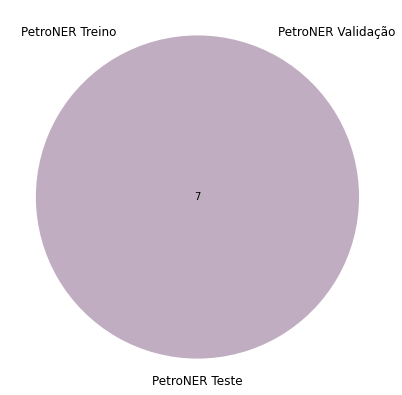

In [15]:
print(len(cont_nenhum), ' URIs da ontologia não aparece no PetroNER e as demais ', 
      len(onto_classes) + len(onto_individual) - len(cont_nenhum), ' seguem a seguinte distribuição:')

plt.figure(figsize=(7,7))
venn3(subsets = (len(cont_treino), 
                 len(cont_valid), 
                 len(cont_treino_valid), 
                 len(cont_test), 
                 len(cont_treino_teste), 
                 len(cont_valid_teste), 
                 len(cont_treino_valid_teste)), 
      set_labels = ('PetroNER Treino', 'PetroNER Validação', 'PetroNER Teste'))

Ontologia povoada (excluindo os indivíduos e classes presentes na ontologia não povoada)

In [16]:
onto_povoada_classes, onto_povoada_individual = extract_classes_e_individuals(onto_povoada)

onto_povoada_classes = list(set(onto_povoada_classes) - set(onto_classes))
onto_povoada_individual = list(set(onto_povoada_individual) - set(onto_individual))

print('Ontologia não povoada')
print('Total de classes: ', len(onto_povoada_classes))
print('Total de individuals: ', len(onto_povoada_individual))
print('Total de classes + individuals: ', len(onto_povoada_classes) + len(onto_povoada_individual))

Ontologia não povoada
Total de classes:  626
Total de individuals:  32384
Total de classes + individuals:  33010


In [17]:
(cont_nenhum_povoada,
 cont_treino_povoada,
 cont_valid_povoada,
 cont_test_povoada,
 cont_treino_valid_povoada,
 cont_treino_teste_povoada,
 cont_valid_teste_povoada, 
 cont_treino_valid_teste_povoada) = set_for_venn_diagram(onto_povoada_classes + 
                                                         onto_povoada_individual)

32198  URIs da ontologia não aparece no PetroNER e as demais  812  seguem a seguinte distribuição:


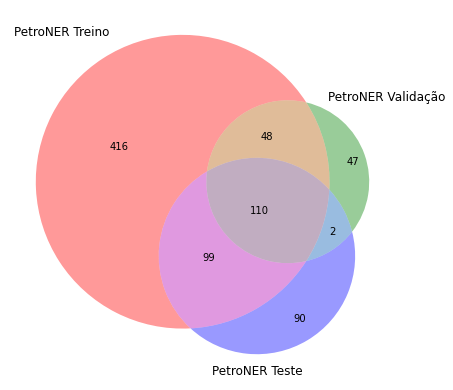

In [18]:
print(len(cont_nenhum_povoada), ' URIs da ontologia não aparece no PetroNER e as demais ', 
      len(onto_povoada_classes) + len(onto_povoada_individual) - len(cont_nenhum_povoada), ' seguem a seguinte distribuição:')

plt.figure(figsize=(7,7))
venn3(subsets = (len(cont_treino_povoada), 
                 len(cont_valid_povoada), 
                 len(cont_treino_valid_povoada), 
                 len(cont_test_povoada), 
                 len(cont_treino_teste_povoada), 
                 len(cont_valid_teste_povoada), 
                 len(cont_treino_valid_teste_povoada)), 
      set_labels = ('PetroNER Treino', 'PetroNER Validação', 'PetroNER Teste'))

### Verificando as entidades novas anotadas no PetrNER
  
  Entidades novas são aquelas URI anotada no PetroNER, mas que não estão presentes na ontologia não povoada nem na ontologia povoada com as listas.

In [26]:
URI_onto = onto_classes + onto_individual + onto_povoada_classes + onto_povoada_individual

new_entity = []

for i in set(PetroNER_ENT_URI): #treino_ENT_URI, PetroNER_ENT_URI
    if i not in URI_onto:
        new_entity.append(i)
        
len(new_entity)

99

In [27]:
new_entity

['#externo_grupo_002',
 '#INTER_BACIA_025',
 '#INTER_BACIA_010',
 '#EXTERNO_EST_FISICA_ROCHA_001',
 '#inter_membro_002',
 '#externo_textura_001',
 '#INTER_CAMPO_0001',
 '#externo_grupo_005',
 '#inter_membro_005',
 '#inter_formacao_006',
 '#INTER_BACIA_019',
 '#inter_membro_011',
 '#INTER_BACIA_011',
 '#INTER_BACIA_003',
 '#INTER_BACIA_009',
 '#externo_grupo_004',
 '#inter_membro_004',
 '#inter_formacao_026',
 '#INTER_BACIA_021',
 '#inter_formacao_016',
 '#inter_formacao_002',
 '#INTER_BACIA_005',
 '#inter_formacao_017',
 '#EXTERNO_EST_FISICA_ROCHA_004',
 '#inter_formacao_019',
 '#INTER_CAMPO_0002',
 '#externo_formacao_003',
 '#inter_formacao_010',
 '#INTER_BACIA_008',
 '#externo_grupo_003',
 '#INTER_BACIA_014',
 '#Mesoriodaserra_Age',
 '#INTER_BACIA_018',
 '#POCO_GENERICO',
 '#Neo-Alagoas_Subage',
 '#inter_formacao_024',
 '#Eoriodaserra_Age',
 '#externo_formacao_001',
 '#inter_formacao_004',
 '#externo_textura_006',
 '#inter_membro_012',
 '#inter_formacao_018',
 '#EXTERNO_EST_FISICA_RO